**Install geopandas and all the dependencies using the below command. You should have anaconda installed.**

conda install -c conda-forge geopandas

Most of the times you will have to install all the dependencies separately.

In [1]:
import pandas as pd
import geopandas
import contextily
import matplotlib.pyplot as plt
import descartes
import rasterio
import folium
import branca
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

In [2]:
#Read the paris restaurants data
data = pd.read_csv(r"data\paris_restaurants.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5735 entries, 0 to 5734
Data columns (total 3 columns):
type    5735 non-null object
x       5735 non-null float64
y       5735 non-null float64
dtypes: float64(2), object(1)
memory usage: 134.5+ KB


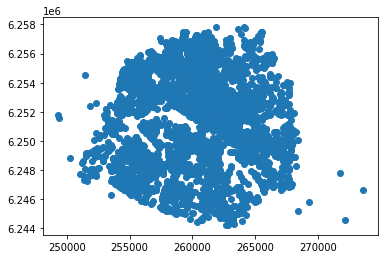

In [4]:
fig, ax = plt.subplots()
ax.plot(data.x, data.y, 'o')
plt.show()

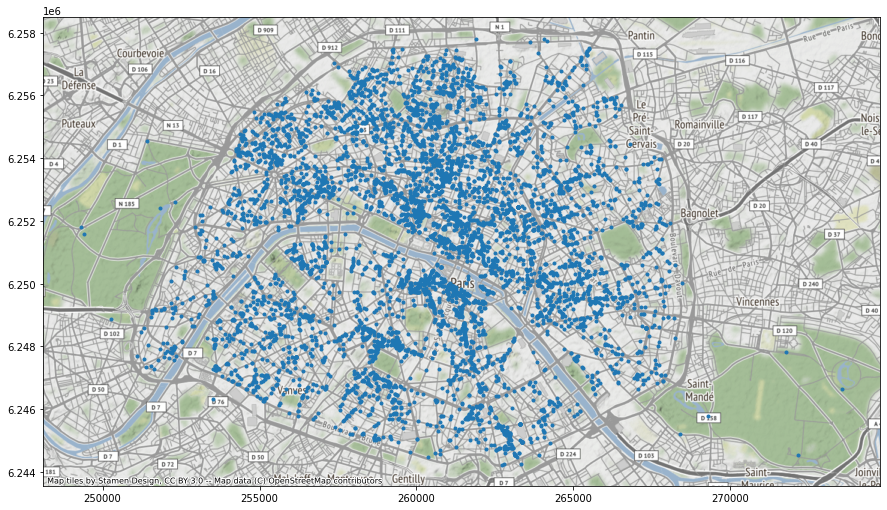

In [5]:
# A figure of all restaurants with background
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(data.x, data.y, 'o', markersize = 3)
contextily.add_basemap(ax)
plt.show()

Let's convert our pandas dataframe to geopandas dataframe.

These are the most common geospatial dataset formats <br>
ESRI shapefile <br>
GeoJSON <br>
GeoPackage(.gpkg)

In [6]:
# Convert it to a GeoDataFrame
geo_rest = geopandas.GeoDataFrame(data, geometry=geopandas.points_from_xy(data.x, data.y))

In [7]:
type(geo_rest)

geopandas.geodataframe.GeoDataFrame

In [8]:
geo_rest.head()

,type,x,y,geometry
0,European restuarant,259641.691646,6.251867e+06,POINT (259641.692 6251867.063)
1,Traditional French restaurant,259572.339603,6.252030e+06,POINT (259572.340 6252029.683)
2,Traditional French restaurant,259657.276374,6.252143e+06,POINT (259657.276 6252143.401)
3,Indian / Middle Eastern restaurant,259684.438330,6.252203e+06,POINT (259684.438 6252203.137)
4,Traditional French restaurant,259597.943086,6.252230e+06,POINT (259597.943 6252230.044)


All the pandas operations and manipulations are applicable to geopandas as well.

In [9]:
geo_rest.groupby('type').size()

type
African restaurant                        138
Asian restaurant                         1642
Caribbean restaurant                       27
Central and South American restuarant      97
European restuarant                      1178
Indian / Middle Eastern restaurant        394
Maghrebian restaurant                     207
Other world restaurant                    107
Traditional French restaurant            1945
dtype: int64

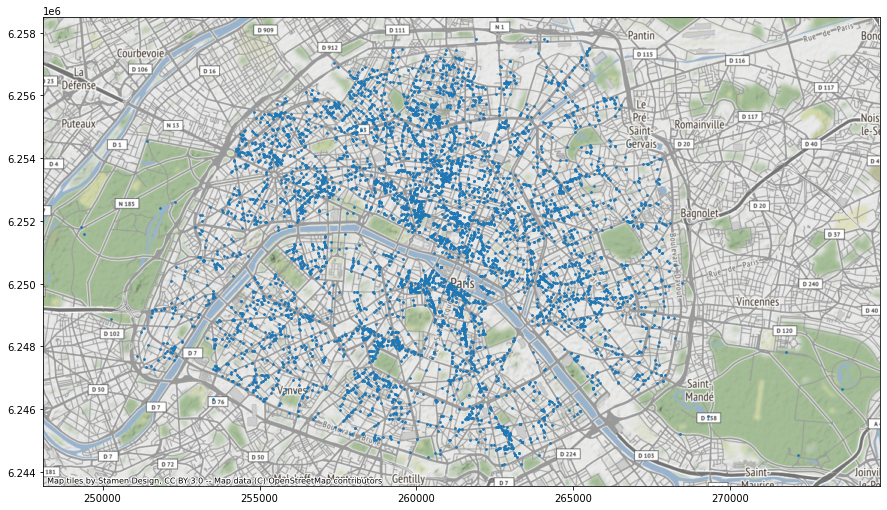

In [10]:
# A figure of all restaurants with background
ax = geo_rest.plot(markersize = 3,figsize = (15, 10))
contextily.add_basemap(ax)
plt.show()

Districts dataset with polygon geometry

In [11]:
districts = geopandas.read_file("data\paris_districts_utm.geojson")

In [12]:
districts.crs

{'init': 'epsg:4326'}

In [13]:
districts.head()

,id,district_name,population,geometry
0,1,St-Germain-l'Auxerrois,1672,"POLYGON ((451922.133 5411438.484, 451922.080 5..."
1,2,Halles,8984,"POLYGON ((452278.419 5412160.893, 452192.407 5..."
2,3,Palais-Royal,3195,"POLYGON ((451553.806 5412340.522, 451528.058 5..."
3,4,Place-Vendôme,3044,"POLYGON ((451004.908 5412654.095, 450960.640 5..."
4,5,Gaillon,1345,"POLYGON ((451328.752 5412991.278, 451294.721 5..."


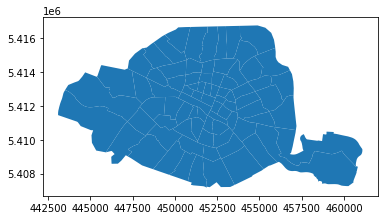

In [14]:
districts.plot()

In [15]:
#area of the districts
districts.geometry.area

0     8.685379e+05
1     4.122371e+05
2     2.735494e+05
3     2.693111e+05
4     1.879097e+05
          ...     
75    1.294254e+06
76    8.061191e+05
77    1.486139e+06
78    1.598127e+06
79    2.089783e+06
Length: 80, dtype: float64

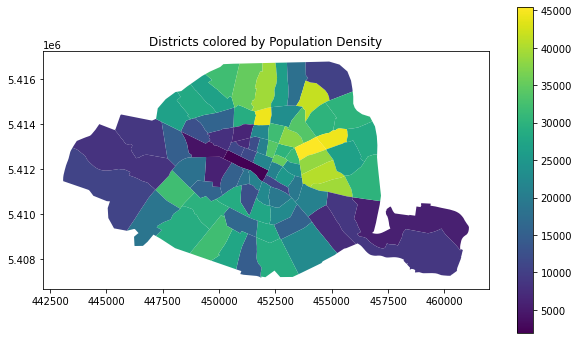

In [16]:
# Add a population density column
districts['population_density'] = districts['population'] / districts.geometry.area * 10**6

# Make a plot of the districts colored by the population density
districts.plot(column='population_density', legend=True,figsize = (10,6))
plt.title(label="Districts colored by Population Density")
plt.show()

Let's plot the indian restaurants in paris.

In [17]:
#subset the geopandas dataframe with Indian restaurants
Indian_restaurants = geo_rest[geo_rest["type"] == "Indian / Middle Eastern restaurant"]

Indian restaurants are spread all over paris. Majority being in the north.

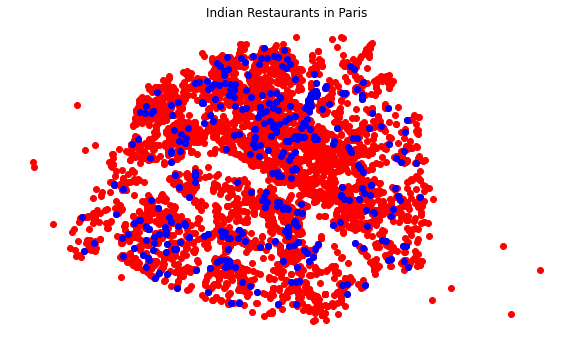

In [18]:
fig, ax = plt.subplots(figsize = (10,6))
geo_rest.plot(ax=ax,color='red')
Indian_restaurants.plot(ax=ax,color='blue')
# Remove the box, ticks and labels
ax.set_axis_off()
plt.title(label='Indian Restaurants in Paris')
plt.show()

shapely provides us functionality to create polygon, line and point geometry for geospatial data.

In [19]:
from shapely.geometry import Point

In [20]:
eiffel_tower = Point(255422.6,6250868.9)
print(eiffel_tower)

POINT (255422.6 6250868.9)


In [21]:
districts.contains(eiffel_tower)

0     False
1     False
2     False
3     False
4     False
      ...  
75    False
76    False
77    False
78    False
79    False
Length: 80, dtype: bool

In [22]:
districts[districts.contains(eiffel_tower)]

,id,district_name,population,geometry,population_density


some useful functions of shapely

In [23]:
district_montparnasse = districts.loc[52, 'geometry']
resto = geo_rest.loc[956, 'geometry']

# Is the Eiffel Tower located within the Montparnasse district?
print(eiffel_tower.within(district_montparnasse))

# Does the Montparnasse district contains the restaurant?
print(district_montparnasse.contains(resto))

# The distance between the Eiffel Tower and the restaurant?
print(eiffel_tower.distance(resto))

False
False
4431.459825586486


Restaurants closest to eiffel tower

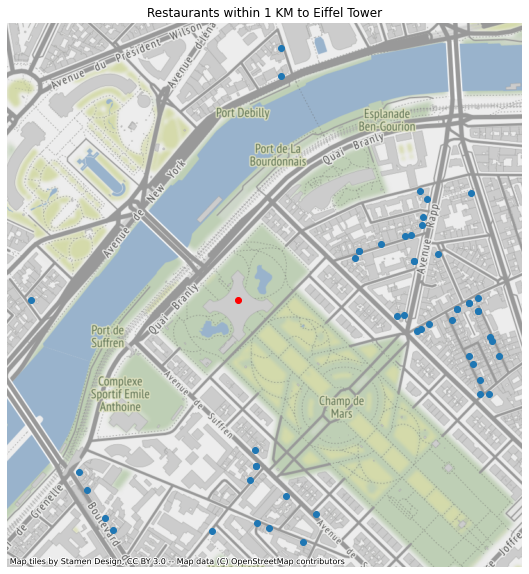

In [24]:
# The distance from each restaurant to the Eiffel Tower
dist_eiffel = geo_rest.distance(eiffel_tower)

# Filter the restaurants for closer than 1 km
restaurants_eiffel = geo_rest[dist_eiffel < 1000]

# Make a plot of the close-by restaurants
ax = restaurants_eiffel.plot(figsize=(10,10))
geopandas.GeoSeries([eiffel_tower]).plot(ax=ax, color='red')
contextily.add_basemap(ax)
ax.set_axis_off()
plt.title(label='Restaurants within 1 KM to Eiffel Tower')
plt.show()

spatial join operation

In [25]:
bikestations = geopandas.read_file(r"data\paris_sharing_bike_stations_utm.geojson")

In [26]:
bikestations.head()

,name,bike_stands,available_bikes,geometry
0,14002 - RASPAIL QUINET,44,4,POINT (450804.449 5409797.268)
1,20503 - COURS DE VINCENNES PYRÉNÉES,21,3,POINT (456414.352 5410698.461)
2,20011 - PYRÉNÉES-DAGORNO,21,0,POINT (456366.909 5411563.320)
3,31008 - VINCENNES (MONTREUIL),56,0,POINT (458730.707 5411789.995)
4,43006 - MINIMES (VINCENNES),28,27,POINT (458234.930 5409991.067)


This adds the district details to all the bike stations within that district

In [27]:
stations_joined = geopandas.sjoin(bikestations, districts, op='within')

In [28]:
stations_joined.head()

,name,bike_stands,available_bikes,geometry,index_right,id,district_name,population,population_density
0,14002 - RASPAIL QUINET,44,4,POINT (450804.449 5409797.268),52,53,Montparnasse,18570,16497.225232
143,14112 - FAUBOURG SAINT JACQUES CASSINI,16,0,POINT (451419.447 5409421.529),52,53,Montparnasse,18570,16497.225232
293,14033 - DAGUERRE GASSENDI,38,1,POINT (450708.228 5409406.941),52,53,Montparnasse,18570,16497.225232
346,14006 - SAINT JACQUES TOMBE ISSOIRE,22,0,POINT (451340.026 5409124.575),52,53,Montparnasse,18570,16497.225232
429,14111 - DENFERT-ROCHEREAU CASSINI,24,8,POINT (451274.511 5409609.731),52,53,Montparnasse,18570,16497.225232


Trees data in Paris

In [29]:
trees = geopandas.read_file("paris_trees_small.gpkg")

In [30]:
trees.head()

,species,location_type,geometry
0,Marronnier,Alignement,POINT (455834.122 5410780.606)
1,Marronnier,Alignement,POINT (446546.284 5412574.697)
2,Marronnier,Alignement,POINT (449768.283 5409876.557)
3,Marronnier,Alignement,POINT (451779.708 5409292.071)
4,Sophora,Alignement,POINT (447041.361 5409756.712)


A spatial join to get trees data within districts

A warning on CRS (coordinate reference system), which defines a specific map projection, as well as transformations between different spatial reference systems. You can use to_crs to change the crs.

In [31]:
dist_trees = geopandas.sjoin(trees, districts, op='within')

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:32631'} != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [32]:
dist_trees = dist_trees.groupby('district_name').size().to_frame(name='n_trees')

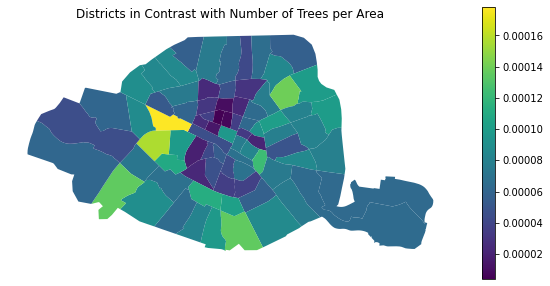

In [33]:
# Merge the 'districts' and 'trees_by_district' dataframes
districts_trees = pd.merge(districts, dist_trees, on='district_name')

# Add a column with the tree density
districts_trees['n_trees_per_area'] = districts_trees['n_trees'] / districts_trees.geometry.area

# Make of map of the districts colored by 'n_trees_per_area'
ax=districts_trees.plot(column='n_trees_per_area', figsize = (10,5), legend=True)
ax.set_axis_off()
plt.title(label='Districts in Contrast with Number of Trees per Area')
plt.show()

Lets plot some famous places and restaurants around eiffel tower

In [34]:
paris_rest = pd.read_csv(r"data\restaurants-casvp.csv",sep=";")
paris_rest.columns = [c.strip().lower().replace(' ', '_') for c in paris_rest.columns]

In [35]:
#drop na's
paris_rest.dropna(inplace=True)

In [36]:
paris_rest.head()

,code,nom_restaurant,adresse,ville,tt,type
0,75002,SAINT-SAUVEUR,"8, RUE SAINT-SAUVEUR",PARIS,"48.865929,2.349476",E
1,75002,GRAMONT,"28, RUE GRAMONT",PARIS,"48.870961,2.33703",E
2,75013,TOLBIAC,"166, RUE DE TOLBIAC",PARIS,"48.826031,2.352555",E
3,75017,EPINETTES,"51, RUE DES EPINETTES",PARIS,"48.896416,2.323344",S
4,75012,BRECHE AUX LOUPS,"32, RUE DE LA BRECHE AUX LOUPS",PARIS,"48.837994,2.394822",E


In [37]:
#use string function to split the tt column to get latitude and longitude
split_val = paris_rest["tt"].str.split(",",expand = True)
paris_rest["lat"] = split_val[0]
paris_rest["lon"] = split_val[1]
paris_rest[["lat", "lon"]] = paris_rest[["lat", "lon"]].apply(pd.to_numeric)

In [38]:
# Convert it to a GeoDataFrame
paris_geo = geopandas.GeoDataFrame(paris_rest, geometry=geopandas.points_from_xy(paris_rest.lon,paris_rest.lat))

In [39]:
paris_geo.head()

,code,nom_restaurant,adresse,ville,tt,type,lat,lon,geometry
0,75002,SAINT-SAUVEUR,"8, RUE SAINT-SAUVEUR",PARIS,"48.865929,2.349476",E,48.865929,2.349476,POINT (2.34948 48.86593)
1,75002,GRAMONT,"28, RUE GRAMONT",PARIS,"48.870961,2.33703",E,48.870961,2.337030,POINT (2.33703 48.87096)
2,75013,TOLBIAC,"166, RUE DE TOLBIAC",PARIS,"48.826031,2.352555",E,48.826031,2.352555,POINT (2.35255 48.82603)
3,75017,EPINETTES,"51, RUE DES EPINETTES",PARIS,"48.896416,2.323344",S,48.896416,2.323344,POINT (2.32334 48.89642)
4,75012,BRECHE AUX LOUPS,"32, RUE DE LA BRECHE AUX LOUPS",PARIS,"48.837994,2.394822",E,48.837994,2.394822,POINT (2.39482 48.83799)


In [40]:
#defining a point geometry for the location of eiffel tower
eiffel_tower = Point(2.2922926,48.8583736)

In [41]:
#get the distance from each restaurant to eiffel tower
paris_geo["dist_et"] = paris_geo.distance(eiffel_tower) * 100

Let's write a function with takes in the index and customizes our popup by using html to display details about the location.

In [42]:
def pop_html(row):

    i = row

    Restaurant = paris_geo['nom_restaurant'].iloc[i]                             
    Code = paris_geo['code'].iloc[i]                           
    Address = paris_geo['adresse'].iloc[i]
    City = paris_geo['ville'].iloc[i]                                           
    Distance_ET = str(round(paris_geo['dist_et'].iloc[i],1)) + str(" KM")                               

    left_col_colour = "#2A799C"
    right_col_colour = "#C5DCE7"

    html = """<!DOCTYPE html>

    <html>

    <table style="height: 126px; width: 300px;">
    <tbody>
    <tr>
    <td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">Restaurant Name</span></td>
    <td style="width: 200px;background-color: """+ right_col_colour +""";">{}</td>""".format(Restaurant) + """
    </tr>
    <tr>
    <td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">Address</span></td>
    <td style="width: 200px;background-color: """+ right_col_colour +""";">{}</td>""".format(Address) + """
    </tr>
    <tr>
    <td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">City</span></td>
    <td style="width: 200px;background-color: """+ right_col_colour +""";">{}</td>""".format(City) + """
    </tr>
    <tr>
    <td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">Code</span></td>
    <td style="width: 200px;background-color: """+ right_col_colour +""";">{}</td>""".format(Code) + """
    </tr>
    <tr>
    <td style="background-color: """+ left_col_colour +""";"><span style="color: #ffffff;">Distance from Eiffel Tower</span></td>
    <td style="width: 200px;background-color: """+ right_col_colour +""";">{}</td>""".format(Distance_ET) + """
    </tr>
    </tbody>
    </table>
    </html>
    """
    return html

In [43]:
eiffel_tower = [ 48.8583736,2.2922926 ]
#define a map
rest_map = folium.Map(location=[paris_geo['lat'].mean(), 
                                paris_geo['lon'].mean()], 
                                zoom_start=11, tiles = "cartodbpositron")

#adding eiffel tower location to the map
folium.Marker(eiffel_tower,  popup  =  "Eiffel Tower", icon=folium.Icon(color='red',icon='heart')).add_to(rest_map) 

folium.CircleMarker(eiffel_tower,  popup  =  "Eiffel Tower",radius = 5 ).add_to(rest_map) 

#cluster to enhance the functionality by clustering a set of locations 
mc = MarkerCluster()
    


#loop which adds location to the map, adds custom icon and calls the pop_html function to customize popup
for i in range(0,len(paris_geo)):
    html = pop_html(i)
 
    iframe = branca.element.IFrame(html=html,width=350,height=200)
    popup = folium.Popup(iframe,parse_html=True)
    
    icon_url = r'icons\french_rest.png'
    icon = folium.features.CustomIcon(icon_url,icon_size=(25,25))

    mc.add_child(folium.Marker([paris_geo['lat'].iloc[i],paris_geo['lon'].iloc[i]],
                  popup=popup,icon=icon))


rest_map.add_child(mc)
rest_map

**Folium maps do not render on Github. Click on the below link to get dynamic output**

https://nbviewer.jupyter.org/github/deva-k/Geo-Spatial/blob/master/GeoSpatial.ipynb